#  ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png)  Project 2 - Singapore Housing Data and Kaggle Challenge Notebook 2

--- 
# Part 2 
---

## Contents: 
- [Importing Cleaned Data](#Importing-Cleaned-Data)
- [Train Test Split](#Train-Test-Split)
- [Modelling](#Modelling)
- [Coefficients of Best Model](#Coef-Best-Model)
- [Output Of Best Predictions](#Prediction-Results)
- [Conclusion](#Conclusion)

<a id='Importing-Cleaned-Data'></a>

## Importing Cleaned Data
---

In [1]:
# !pip install --upgrade numpy==1.22.2 
# To get rid of an error at the second half of the notebook (at the ridge regression stage)

In [4]:
# Importing packages
import numpy as np
import pandas as pd
import os

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn import metrics

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
train = pd.read_csv('output/train.csv')
test = pd.read_csv('data/test.csv', low_memory = False)

In [8]:
pd.set_option('display.max_columns', None)
train.head()

,flat_type,floor_area_sqm,flat_model,lease_commence_date,resale_price,tranc_year,tranc_month,lower,upper,hdb_age,max_floor_lvl,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,mall_within_500m,mall_within_1km,mall_within_2km,hawker_within_500m,hawker_within_1km,hawker_within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,mrt_name,bus_interchange,mrt_interchange,bus_stop_nearest_distance,pri_sch_nearest_distance,vacancy,pri_sch_affiliation,sec_sch_nearest_dist,cutoff_point,affiliation
0,4 Room,90.0,Model A,2006,680000.0,2016,5,10,12,15,25,0,0,0,96,46,0,0,0,0,0,0,0,0,0,7,1,3,13,84,60,330.083069,Kallang,0,0,29.427395,1138.633422,78,1,1138.633422,224,0
1,5 Room,130.0,Improved,1987,665000.0,2012,7,7,9,34,9,0,0,0,56,56,0,0,0,0,0,0,0,0,1,3,0,1,7,80,77,903.659703,Bishan,1,1,58.207761,415.607357,45,1,447.894399,232,0
2,Executive,144.0,Apartment,1997,838000.0,2013,7,13,15,24,16,0,0,0,0,30,60,0,0,0,0,0,0,0,0,4,0,0,1,84,95,1334.251197,Bukit Batok,1,0,214.747860,498.849039,39,0,180.074558,188,0
3,4 Room,103.0,Model A,1992,550000.0,2012,4,1,5,29,11,0,0,0,68,7,0,0,0,0,0,0,0,0,1,4,0,1,9,32,86,907.453484,Bishan,1,1,43.396521,389.515528,20,1,389.515528,253,1
4,4 Room,83.0,Simplified,1987,298000.0,2017,12,1,3,34,4,0,0,0,30,18,0,0,0,0,0,0,0,0,1,2,0,0,1,45,0,412.343032,Khatib,0,0,129.422752,401.200584,74,0,312.025435,208,0


<a id='Train-Test-Split'></a>
## Train Test Split

---

### Splitting Our Data

Before scaling or categorising our data, we first have to split them to prevent any data leakages, ensuring the most accurate predictions can be made.

As the size of the data is over 100,000 rows, we will be using an 80/20 train test split size.

In [5]:
X = train.drop(columns = 'resale_price')
y = train['resale_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 123, test_size= 0.2)

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(119844, 41)
(119844,)
(29961, 41)
(29961,)


In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119844 entries, 2448 to 15725
Data columns (total 41 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   flat_type                  119844 non-null  object 
 1   floor_area_sqm             119844 non-null  float64
 2   flat_model                 119844 non-null  object 
 3   lease_commence_date        119844 non-null  int64  
 4   tranc_year                 119844 non-null  int64  
 5   tranc_month                119844 non-null  int64  
 6   lower                      119844 non-null  int64  
 7   upper                      119844 non-null  int64  
 8   hdb_age                    119844 non-null  int64  
 9   max_floor_lvl              119844 non-null  int64  
 10  1room_sold                 119844 non-null  int64  
 11  2room_sold                 119844 non-null  int64  
 12  3room_sold                 119844 non-null  int64  
 13  4room_sold                 

### Train Data

#### **<u>Splitting Categorical and Numerical</u>**

Checking our train data only, we will filter through the columns we would like to be treated as categorical, and numerical.

In this case, we will treat the transaction year and month as categorical values, as the trends with the market should be taken into account in our model, and the trends are not a constant increase or decrease etc.

In [8]:
categories = ['flat_type', 'flat_model', 'mrt_name', 'tranc_year', 'tranc_month']
X_train_cat = X_train[categories]
X_train_num = X_train.drop(columns = categories)

In [9]:
X_train_cat.head()

,flat_type,flat_model,mrt_name,tranc_year,tranc_month
2448,4 Room,Model A,Punggol,2017,7
141108,Executive,Apartment,Pasir Ris,2019,9
8870,3 Room,Model A,Dover,2019,3
71105,4 Room,Model A,Bukit Panjang,2020,9
25560,4 Room,Model A,Tiong Bahru,2012,10


In [10]:
X_train_num.head()

,floor_area_sqm,lease_commence_date,lower,upper,hdb_age,max_floor_lvl,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,mall_within_500m,mall_within_1km,mall_within_2km,hawker_within_500m,hawker_within_1km,hawker_within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_interchange,mrt_interchange,bus_stop_nearest_distance,pri_sch_nearest_distance,vacancy,pri_sch_affiliation,sec_sch_nearest_dist,cutoff_point,affiliation
2448,85.0,2004,10,12,17,18,0,0,0,60,60,0,0,0,0,0,0,0,1,3,6,0,0,0,40,0,1466.005898,1,1,113.731184,173.030975,106,0,216.972809,203,0
141108,148.0,1996,10,12,25,16,0,0,0,0,0,53,0,0,0,0,0,0,0,1,3,0,0,1,42,0,1668.921051,1,0,86.125056,562.982664,52,0,2073.970843,220,0
8870,70.0,2012,34,36,9,40,0,0,76,195,0,1,0,0,0,0,0,0,0,2,4,0,1,7,72,158,780.928215,0,0,150.473848,658.860745,32,1,475.511606,241,0
71105,93.0,2015,19,21,6,28,0,0,0,130,48,0,0,0,0,0,0,0,0,3,11,0,0,1,28,45,964.763401,1,1,96.272825,440.849801,64,0,302.059533,220,0
25560,91.0,2003,28,30,18,30,0,0,0,58,85,0,0,0,0,0,0,0,1,1,3,1,6,15,28,96,406.509012,0,0,170.185950,259.768928,62,0,814.169240,235,0


#### **<u>Scaling Numerical Values</u>**

As the range of our numerical values are very large, let's scale them down so we make sure no column are weighted more than others.

In [11]:
sc = StandardScaler()

In [12]:
X_train_num_scaled = pd.DataFrame(sc.fit_transform(X_train_num), columns = X_train_num.columns, index=X_train_num.index)

In [13]:
X_train_num_scaled.head()

,floor_area_sqm,lease_commence_date,lower,upper,hdb_age,max_floor_lvl,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,mall_within_500m,mall_within_1km,mall_within_2km,hawker_within_500m,hawker_within_1km,hawker_within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_interchange,mrt_interchange,bus_stop_nearest_distance,pri_sch_nearest_distance,vacancy,pri_sch_affiliation,sec_sch_nearest_dist,cutoff_point,affiliation
2448,-0.502249,0.970553,0.508935,0.496229,-0.970553,0.470625,-0.024347,-0.150193,-0.568402,0.222967,1.003419,-0.310740,-0.021795,-0.082412,-0.030236,-0.055579,-0.088974,-0.013513,0.697397,0.850053,0.232793,-0.637421,-0.822733,-0.946841,-0.456169,-1.049438,1.636838,0.911235,1.680184,-0.028310,-0.947415,2.836690,-0.356816,-0.939902,-0.356550,-0.181352
141108,2.077852,0.305508,0.508935,0.496229,-0.305508,0.146636,-0.024347,-0.150193,-0.568402,-1.105786,-0.786894,2.453227,-0.021795,-0.082412,-0.030236,-0.055579,-0.088974,-0.013513,-0.671805,-0.561293,-0.633739,-0.637421,-0.822733,-0.697379,-0.351778,-1.049438,2.110016,0.911235,-0.595173,-0.524783,0.718915,-0.182570,-0.356816,5.082717,0.493325,-0.181352
8870,-1.116559,1.635598,4.896593,4.890321,-1.635598,4.034498,-0.024347,-0.150193,0.534480,3.212662,-0.786894,-0.258590,-0.021795,-0.082412,-0.030236,-0.055579,-0.088974,-0.013513,-0.671805,0.144380,-0.344895,-0.637421,-0.237409,0.799392,1.214081,1.798342,0.039306,-1.097411,-0.595173,0.632477,1.128619,-1.300814,2.802566,-0.101409,1.543170,-0.181352
71105,-0.174617,1.884990,2.154307,2.144013,-1.884990,2.090567,-0.024347,-0.150193,-0.568402,1.773179,0.645357,-0.310740,-0.021795,-0.082412,-0.030236,-0.055579,-0.088974,-0.013513,-0.671805,0.850053,1.677014,-0.637421,-0.822733,-0.697379,-1.082513,-0.238361,0.467991,0.911235,1.680184,-0.342284,0.197021,0.488377,-0.356816,-0.663949,0.493325,-0.181352
25560,-0.256525,0.887422,3.799678,3.791798,-0.887422,2.414555,-0.024347,-0.150193,-0.568402,0.178675,1.749384,-0.310740,-0.021795,-0.082412,-0.030236,-0.055579,-0.088974,-0.013513,0.697397,-0.561293,-0.633739,0.667338,2.689211,2.795087,-1.082513,0.680859,-0.833802,-1.097411,-0.595173,0.986983,-0.576769,0.376552,-0.356816,0.996926,1.243215,-0.181352


#### **<u>OneHotEncoding categories</u>**

Now that the easy part of scaling is done, we will need split our categories's unique values into separate columns.

In [14]:
list(X_train_cat.columns)

['flat_type', 'flat_model', 'mrt_name', 'tranc_year', 'tranc_month']

In [15]:
#Printing value counts of all unique values in each columnn
for col in X_train_cat.columns:
    print(f'{X_train_cat[col].value_counts()} \n')

4 Room              48588
3 Room              30942
5 Room              29164
Executive            9511
2 Room               1520
1 Room                 71
Multi-Generation       48
Name: flat_type, dtype: int64 

Model A                   36601
Improved                  30833
New Generation            18655
Premium Apartment         11903
Simplified                 5834
Apartment                  4781
Standard                   3852
Maisonette                 3499
Model A2                   1670
DBSS                       1312
Adjoined flat               215
Model A-Maisonette          209
Type S1                     191
Type S2                      96
Terrace                      76
Multi Generation             48
Premium Apartment Loft       36
Improved-Maisonette          16
Premium Maisonette           14
2-room                        3
Name: flat_model, dtype: int64 

Punggol          6037
Sengkang         5729
Yishun           5557
Bukit Panjang    4501
Buangkok         4483
   

Considering the above, I would like to make the minimum frequency for the OneHotEncoder to be 15. Let's convert this into percentage, so it tallies according to the datasize.

In [16]:
15/X_train_cat.shape[0]

0.00012516271152498247

In [17]:
# ohe_dictionary = {i : list(X_train_cat[i].unique()) for i in list(X_train_cat.columns)}
# ohe_columns = [x[0] for x in ohe_dictionary]
# ohe_categories = [x[1] for x in ohe_dictionary]

In [18]:
enc = OneHotEncoder(sparse_output=False, drop='first', min_frequency= 0.00015, handle_unknown= 'infrequent_if_exist')

In [19]:
X_train_cat_ohe = pd.DataFrame(enc.fit_transform(X_train_cat), columns=enc.get_feature_names_out(), index=X_train_cat.index)

In [20]:
X_train_cat_ohe.columns = X_train_cat_ohe.columns.str.lower()

In [21]:
X_train_cat_ohe.shape

(119844, 132)

In [22]:
X_train_output = X_train_num_scaled.join(X_train_cat_ohe, on = X_train_num_scaled.index)
X_train_output.head()

,floor_area_sqm,lease_commence_date,lower,upper,hdb_age,max_floor_lvl,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,mall_within_500m,mall_within_1km,mall_within_2km,hawker_within_500m,hawker_within_1km,hawker_within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_interchange,mrt_interchange,bus_stop_nearest_distance,pri_sch_nearest_distance,vacancy,pri_sch_affiliation,sec_sch_nearest_dist,cutoff_point,affiliation,flat_type_2 room,flat_type_3 room,flat_type_4 room,flat_type_5 room,flat_type_executive,flat_type_multi-generation,flat_model_apartment,flat_model_dbss,flat_model_improved,flat_model_maisonette,flat_model_model a,flat_model_model a-maisonette,flat_model_model a2,flat_model_multi generation,flat_model_new generation,flat_model_premium apartment,flat_model_premium apartment loft,flat_model_simplified,flat_model_standard,flat_model_terrace,flat_model_type s1,flat_model_type s2,flat_model_infrequent_sklearn,mrt_name_aljunied,mrt_name_ang mo kio,mrt_name_bartley,mrt_name_beauty world,mrt_name_bedok,mrt_name_bedok north,mrt_name_bedok reservoir,mrt_name_bencoolen,mrt_name_bishan,mrt_name_boon keng,mrt_name_boon lay,mrt_name_botanic gardens,mrt_name_braddell,mrt_name_buangkok,mrt_name_bukit batok,mrt_name_bukit gombak,mrt_name_bukit panjang,mrt_name_buona vista,mrt_name_caldecott,mrt_name_canberra,mrt_name_cashew,mrt_name_changi airport,mrt_name_chinatown,mrt_name_chinese garden,mrt_name_choa chu kang,mrt_name_clarke quay,mrt_name_clementi,mrt_name_commonwealth,mrt_name_dakota,mrt_name_dover,mrt_name_eunos,mrt_name_farrer park,mrt_name_farrer road,mrt_name_geylang bahru,mrt_name_harbourfront,mrt_name_hillview,mrt_name_holland village,mrt_name_hougang,mrt_name_jalan besar,mrt_name_jurong east,mrt_name_kaki bukit,mrt_name_kallang,mrt_name_kembangan,mrt_name_khatib,mrt_name_kovan,mrt_name_labrador park,mrt_name_lakeside,mrt_name_lavender,mrt_name_little india,mrt_name_lorong chuan,mrt_name_macpherson,mrt_name_marsiling,mrt_name_marymount,mrt_name_mattar,mrt_name_mountbatten,mrt_name_nicoll highway,mrt_name_outram park,mrt_name_pasir ris,mrt_name_paya lebar,mrt_name_pioneer,mrt_name_potong pasir,mrt_name_punggol,mrt_name_queenstown,mrt_name_redhill,mrt_name_rochor,mrt_name_sembawang,mrt_name_sengkang,mrt_name_serangoon,mrt_name_simei,mrt_name_tai seng,mrt_name_tampines,mrt_name_tampines east,mrt_name_tampines west,mrt_name_tanah merah,mrt_name_tanjong pagar,mrt_name_telok blangah,mrt_name_tiong bahru,mrt_name_toa payoh,mrt_name_ubi,mrt_name_upper changi,mrt_name_woodlands,mrt_name_woodlands north,mrt_name_woodlands south,mrt_name_woodleigh,mrt_name_yew tee,mrt_name_yio chu kang,mrt_name_yishun,mrt_name_one-north,mrt_name_infrequent_sklearn,tranc_year_2013,tranc_year_2014,tranc_year_2015,tranc_year_2016,tranc_year_2017,tranc_year_2018,tranc_year_2019,tranc_year_2020,tranc_year_2021,tranc_month_2,tranc_month_3,tranc_month_4,tranc_month_5,tranc_month_6,tranc_month_7,tranc_month_8,tranc_month_9,tranc_month_10,tranc_month_11,tranc_month_12
2448,-0.502249,0.970553,0.508935,0.496229,-0.970553,0.470625,-0.024347,-0.150193,-0.568402,0.222967,1.003419,-0.310740,-0.021795,-0.082412,-0.030236,-0.055579,-0.088974,-0.013513,0.697397,0.850053,0.232793,-0.637421,-0.822733,-0.946841,-0.456169,-1.049438,1.636838,0.911235,1.680184,-0.028310,-0.947415,2.836690,-0.356816,-0.939902,-0.356550,-0.181352,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [23]:
X_train_output.shape

(119844, 168)

### Repeating On Test Data

We will have to go through the same process for the test set as the train set.

#### **<u>Splitting Categorical and Numerical</u>**

In [24]:
X_test_cat = X_test[categories]
X_test_num = X_test.drop(columns = categories)

#### **<u>Scaling Numerical Values</u>**

In [25]:
X_test_num_scaled = pd.DataFrame(sc.transform(X_test_num), columns = X_test_num.columns, index=X_test_num.index)

#### **<u>OneHotEncoding categories</u>**

In [26]:
X_test_cat_ohe = pd.DataFrame(enc.transform(X_test_cat), columns=enc.get_feature_names_out(), index=X_test_cat.index)
X_test_cat_ohe.columns = X_test_cat_ohe.columns.str.lower()
X_test_output = X_test_num_scaled.join(X_test_cat_ohe, on = X_test_num_scaled.index)
X_test_output.head()

,floor_area_sqm,lease_commence_date,lower,upper,hdb_age,max_floor_lvl,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,mall_within_500m,mall_within_1km,mall_within_2km,hawker_within_500m,hawker_within_1km,hawker_within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_interchange,mrt_interchange,bus_stop_nearest_distance,pri_sch_nearest_distance,vacancy,pri_sch_affiliation,sec_sch_nearest_dist,cutoff_point,affiliation,flat_type_2 room,flat_type_3 room,flat_type_4 room,flat_type_5 room,flat_type_executive,flat_type_multi-generation,flat_model_apartment,flat_model_dbss,flat_model_improved,flat_model_maisonette,flat_model_model a,flat_model_model a-maisonette,flat_model_model a2,flat_model_multi generation,flat_model_new generation,flat_model_premium apartment,flat_model_premium apartment loft,flat_model_simplified,flat_model_standard,flat_model_terrace,flat_model_type s1,flat_model_type s2,flat_model_infrequent_sklearn,mrt_name_aljunied,mrt_name_ang mo kio,mrt_name_bartley,mrt_name_beauty world,mrt_name_bedok,mrt_name_bedok north,mrt_name_bedok reservoir,mrt_name_bencoolen,mrt_name_bishan,mrt_name_boon keng,mrt_name_boon lay,mrt_name_botanic gardens,mrt_name_braddell,mrt_name_buangkok,mrt_name_bukit batok,mrt_name_bukit gombak,mrt_name_bukit panjang,mrt_name_buona vista,mrt_name_caldecott,mrt_name_canberra,mrt_name_cashew,mrt_name_changi airport,mrt_name_chinatown,mrt_name_chinese garden,mrt_name_choa chu kang,mrt_name_clarke quay,mrt_name_clementi,mrt_name_commonwealth,mrt_name_dakota,mrt_name_dover,mrt_name_eunos,mrt_name_farrer park,mrt_name_farrer road,mrt_name_geylang bahru,mrt_name_harbourfront,mrt_name_hillview,mrt_name_holland village,mrt_name_hougang,mrt_name_jalan besar,mrt_name_jurong east,mrt_name_kaki bukit,mrt_name_kallang,mrt_name_kembangan,mrt_name_khatib,mrt_name_kovan,mrt_name_labrador park,mrt_name_lakeside,mrt_name_lavender,mrt_name_little india,mrt_name_lorong chuan,mrt_name_macpherson,mrt_name_marsiling,mrt_name_marymount,mrt_name_mattar,mrt_name_mountbatten,mrt_name_nicoll highway,mrt_name_outram park,mrt_name_pasir ris,mrt_name_paya lebar,mrt_name_pioneer,mrt_name_potong pasir,mrt_name_punggol,mrt_name_queenstown,mrt_name_redhill,mrt_name_rochor,mrt_name_sembawang,mrt_name_sengkang,mrt_name_serangoon,mrt_name_simei,mrt_name_tai seng,mrt_name_tampines,mrt_name_tampines east,mrt_name_tampines west,mrt_name_tanah merah,mrt_name_tanjong pagar,mrt_name_telok blangah,mrt_name_tiong bahru,mrt_name_toa payoh,mrt_name_ubi,mrt_name_upper changi,mrt_name_woodlands,mrt_name_woodlands north,mrt_name_woodlands south,mrt_name_woodleigh,mrt_name_yew tee,mrt_name_yio chu kang,mrt_name_yishun,mrt_name_one-north,mrt_name_infrequent_sklearn,tranc_year_2013,tranc_year_2014,tranc_year_2015,tranc_year_2016,tranc_year_2017,tranc_year_2018,tranc_year_2019,tranc_year_2020,tranc_year_2021,tranc_month_2,tranc_month_3,tranc_month_4,tranc_month_5,tranc_month_6,tranc_month_7,tranc_month_8,tranc_month_9,tranc_month_10,tranc_month_11,tranc_month_12
40697,-0.543203,-0.359537,-0.039522,-0.053033,0.359537,-0.987323,-0.024347,-0.150193,-0.568402,0.311551,0.406648,-0.310740,-0.021795,-0.082412,-0.030236,-0.055579,-0.088974,-0.013513,-0.671805,-0.561293,-0.633739,-0.637421,-0.237409,0.799392,1.631644,0.338404,0.264956,0.911235,1.680184,-0.304774,-0.404788,-0.573955,2.802566,-0.592627,1.093237,-0.181352,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0

<a id='Modelling'></a>
## Modelling

---

### Linear Regression

In [27]:
lr = LinearRegression()

lr.fit(X_train_output, y_train)

print(f"Linear Regression Train Score: {lr.score(X_train_output, y_train)}")

print(f"Linear Regression Train RMSE: {np.sqrt(metrics.mean_squared_error(y_train, lr.predict(X_train_output)))}")

Linear Regression Train Score: 0.9039752171402733
Linear Regression Train RMSE: 44274.73997839304


In [28]:
print(f"Linear Regression Test Score: {lr.score(X_test_output, y_test)}")

print(f"Linear Regression Test RMSE: {np.sqrt(metrics.mean_squared_error(y_test, lr.predict(X_test_output)))}")

Linear Regression Test Score: 0.9047782802377116
Linear Regression Test RMSE: 44602.73948619131


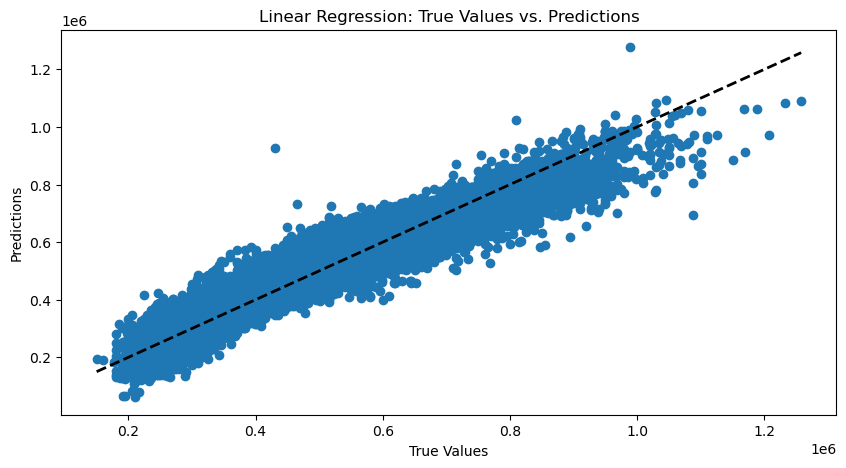

In [29]:
lr_predictions = lr.predict(X_test_output)

plt.figure(figsize= (10,5));
plt.scatter(y_test, lr_predictions);
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2);  # Plotting the 45-degree line
plt.xlabel('True Values');
plt.ylabel('Predictions');
plt.title('Linear Regression: True Values vs. Predictions')

plt.show()

Our Linear Regression model seems to have done a decent job at predicting our true values, despite a few outliers. Let's see if we can get a better prediction model

### Ridge Regression

In [30]:
r_alphas = np.logspace(0, 5, 100)

ridge_cv = RidgeCV(alphas=r_alphas, scoring='r2', cv=3).fit(X_train_output, y_train)

ridge_train_predictions = ridge_cv.predict(X_train_output)

In [31]:
print(f"RidgeCV train score: {ridge_cv.score(X_train_output, y_train)}")

print(f"RidgeCV train RMSE: {np.sqrt(metrics.mean_squared_error(y_train, ridge_train_predictions))}")

RidgeCV train score: 0.9038663989037642
RidgeCV train RMSE: 44299.819623500785


In [32]:
ridge_test_predictions = ridge_cv.predict(X_test_output)

In [33]:
print(f"RidgeCV test score: {ridge_cv.score(X_test_output, y_test)}")

print(f"RidgeCV test RMSE: {np.sqrt(metrics.mean_squared_error(y_test, ridge_test_predictions))}")

RidgeCV test score: 0.9046484554539019
RidgeCV test RMSE: 44633.134697870504


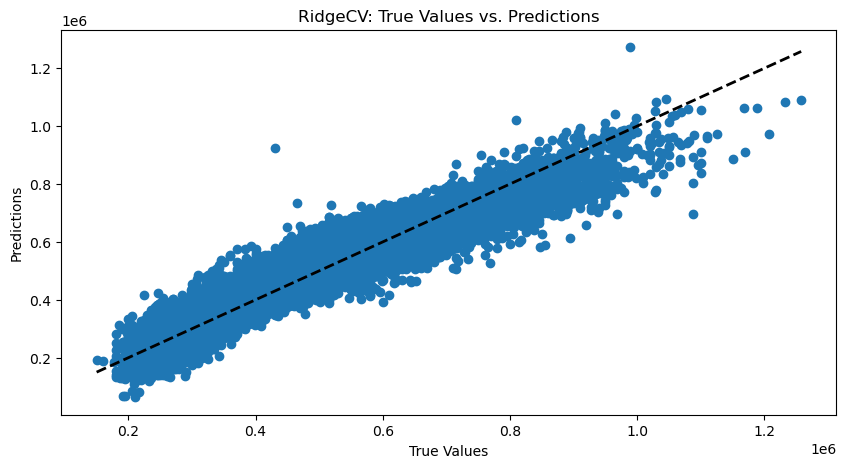

In [92]:
ridge_predictions = ridge_cv.predict(X_test_output)

plt.figure(figsize= (10,5));
plt.scatter(y_test, ridge_predictions);
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2);  # Plotting the 45-degree line
plt.xlabel('True Values');
plt.ylabel('Predictions');
plt.title('RidgeCV: True Values vs. Predictions')

plt.show()

### Lasso Regression

In [47]:
lasso_cv = LassoCV(cv=3, max_iter=30000)

lasso_cv.fit(X_train_output, y_train)

lasso_train_predictions = lasso_cv.predict(X_train_output)

In [93]:
print(f"LassoCV train score: {lasso_cv.score(X_train_output, y_train)}")

print(f"LassoCV train MSE: {np.sqrt(metrics.mean_squared_error(y_train, ridge_cv.predict(X_train_output)))}")

LassoCV train score: 0.8847984257022143
LassoCV train MSE: 44299.819623500785


In [54]:
lasso_test_predictions = ridge_cv.predict(X_test_output)

In [94]:
print(f"LassoCV test score: {lasso_cv.score(X_test_output, y_test)}")

print(f"LassoCV test MSE: {np.sqrt(metrics.mean_squared_error(y_test, ridge_cv.predict(X_test_output)))}")

LassoCV test score: 0.8870108942557346
LassoCV test MSE: 44633.134697870504


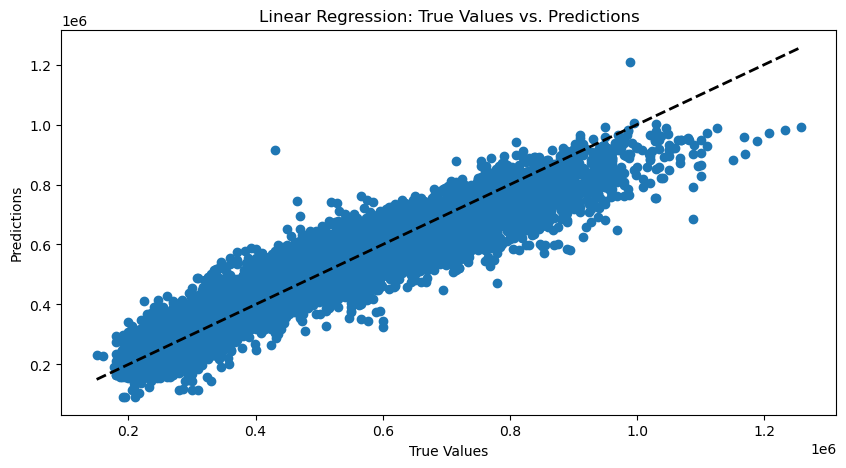

In [96]:
lasso_predictions = lasso_cv.predict(X_test_output)

plt.figure(figsize= (10,5));
plt.scatter(y_test, lasso_predictions);
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2);  # Plotting the 45-degree line
plt.xlabel('True Values');
plt.ylabel('Predictions');
plt.title('Linear Regression: True Values vs. Predictions')

plt.show()

<a id='Coef-Best-Model'></a>
## Coefficients of Best Model

---

RidgeCV gives us the best model with the highest R2 score, and the lowest RMSE. Let's check which factors contribute more to the model.

In [88]:
coefficients = pd.DataFrame(ridge_cv.coef_, columns = ['coef']).join(pd.DataFrame(X_train_output.columns, columns = ['Column'])).sort_values(by = 'coef', ascending = False)
pd.set_option('display.max_row', None)
coefficients

,coef,Column
55,329355.208248,flat_model_terrace
101,307916.854646,mrt_name_kembangan
80,298702.731322,mrt_name_changi airport
91,293948.383683,mrt_name_farrer road
70,267551.914628,mrt_name_botanic gardens
113,245540.206378,mrt_name_mountbatten
95,243811.617228,mrt_name_holland village
147,242805.847534,mrt_name_infrequent_sklearn
133,237017.863764,mrt_name_tanjong pagar
87,229866.896006,mrt_name_dakota


Whether the property is a terrace house or not, affects the price the most. Other notable factors include the location of the housing. Surprisingly, whether the house was around Kembangan or Changi Airport had a large affect to the increase of the resale price. 

We can see that major contributions that affect the resale price, both positively and negatively, are determined by the MRT names, where the houses are closely located.

<a id='Prediction-Results'></a>
## Output Of Best Predictions

---

In [99]:
test_predictions = pd.DataFrame(ridge_test_predictions, columns = ['Predicted'], index=range(len(ridge_test_predictions)))
test_predictions.head()

,Predicted
0,537900.416288
1,321675.294835
2,345676.771412
3,682061.927468
4,364453.347690


In [100]:
id = test[['id']]
id.columns = ['Id']
id.head()

,Id
0,114982
1,95653
2,40303
3,109506
4,100149


In [101]:
test_results = id.join(test_predictions)
test_results.head()

,Id,Predicted
0,114982,537900.416288
1,95653,321675.294835
2,40303,345676.771412
3,109506,682061.927468
4,100149,364453.347690


In [103]:
if not os.path.exists('output'):
    os.makedirs('output') 
test_results.to_csv('output/test_predictions.csv', index= False)

<a id='Conclusion'></a>
## Conclusion

---

We can see that the most important factor that affect resale pricing in Singapore is determined on location. Other factors also include amenities nearby, proximity to primary schools, and size of property.

From the above few models, we can see that it is possible to predict the housing resale price. Evaluating how well our best prediction model faired, it gave us an approximate 0.91 R<sup>2</sup> value, and a RMSE of approximately $44.6K. If more time was given, more improvements can be made to the models, including exploring different combinations of features, and feature engineering.